# Testing basic operators in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
#import Whirl
#import Whirl:@get
using Whirl
#@get Whirl (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Fields);

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Testing body-to-field operations

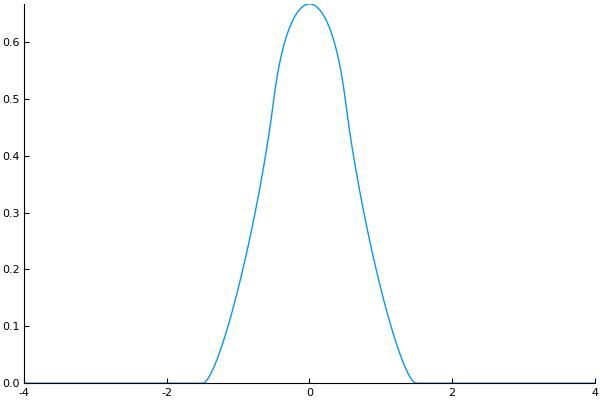

In [3]:
ddf = DDF();
x = linspace(-4,4,401);
plot(x,ddf.(x),legend=false)

In [8]:
x = [0.25,0.75,0.25]; y = [0.75,0.25,0.25];
X = VectorData(x,y);
q = Edges(Primal,(12,12));
dx = 0.1;
H = Regularize(x,y,dx)

Regularization/interpolation operator with non-filtered interpolation
  3 points in grid with cell area 0.01


#### Set up a circle of points

In [2]:
n = 100;
θ = linspace(0,2π,n+1);
x = 0.5 + 0.25*cos.(θ[1:n])
y = 0.5 + 0.25*sin.(θ[1:n])
ds = 2π/n*0.25;
X = VectorData(x,y);

#### Set up the physical dimensions of the grid and create empty data

In [2]:
nx = 102; ny = 102;
Lx = 1.0;
dx = Lx/(nx-2);
q = Edges(Primal,(nx,ny));
w = Nodes(Dual,(nx,ny));
w̃ = Nodes(Primal,w);
p = Edges(Dual,w);

#### Create a regularization operator with the point data

In [4]:
H = Regularize(X,dx;weights=ds)

Regularization/interpolation operator with non-filtered interpolation
  100 points in grid with cell area 0.0001


In [5]:
H̃ = Regularize(X,dx;weights=ds,filter=true)

Regularization/interpolation operator with filtered interpolation
  100 points in grid with cell area 0.0001


#### Now set up some data on the points and regularize it to primal edge data on the grid 

In [6]:
f = VectorData(X)
fill!(f.u,1.0);
f.v .= X.v.-0.5;

In [10]:
@time H(q,f);

  0.052118 seconds (144.23 k allocations: 54.704 MiB, 3.29% gc time)


In [8]:
@time H(q,f);

  0.039923 seconds (20.61 k allocations: 17.606 MiB, 7.88% gc time)


In [8]:
H(q,f);
plot(q)

LoadError: [91mUndefVarError: plot not defined[39m

  0.031107 seconds (144.24 k allocations: 54.705 MiB, 36.17% gc time)


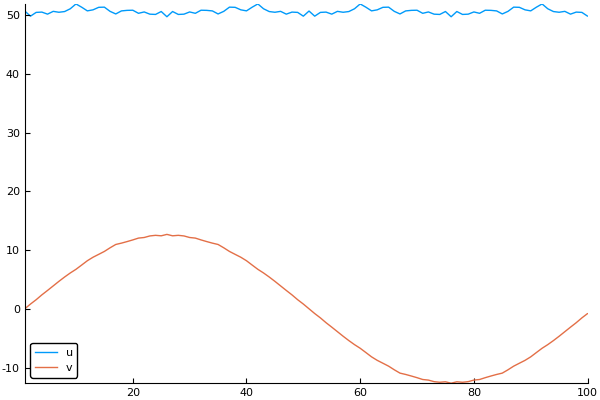

In [13]:
f2 = VectorData(X);
@time H(f2,q);
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Vector data onto dual edge field

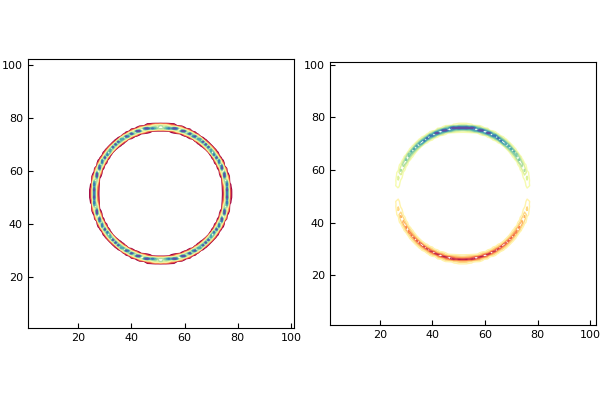

In [14]:
H(p,f);
plot(p)

#### Vector data onto primal and dual nodal data

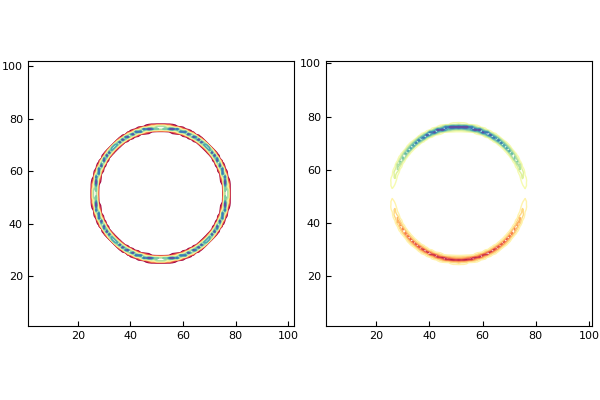

In [15]:
H((w,w̃),f);
plot(plot(w),plot(w̃))

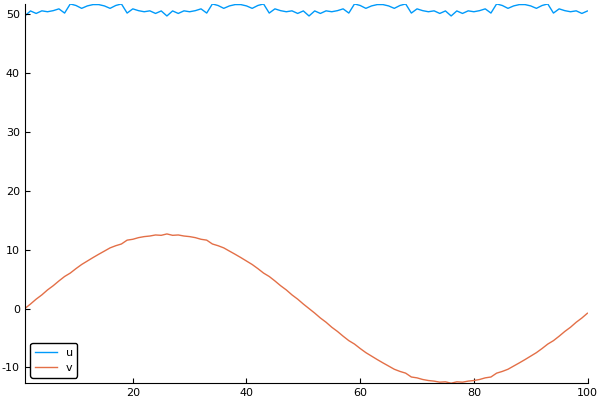

In [16]:
f2 = VectorData(X);
H(f2,(w,w̃));
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Scalar data onto dual nodal field

  0.033761 seconds (72.84 k allocations: 27.623 MiB, 27.66% gc time)


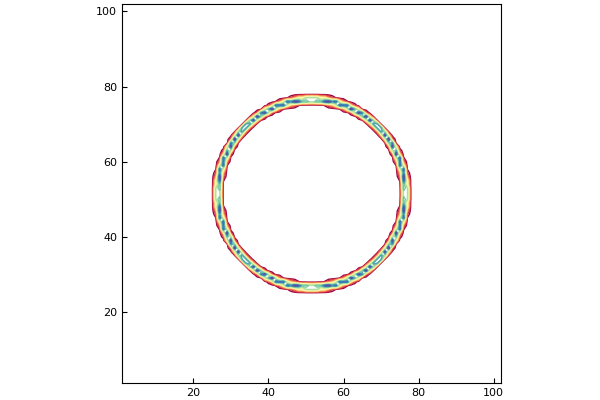

In [8]:
g = ScalarData(X)
fill!(g,1.0)
@time H(w,g)
plot(w)

In [9]:
g = ScalarData(X)
g .= cos.(θ[1:n])+ 0.2*rand(n);

In [10]:
@time H(w,g);

  0.030391 seconds (72.83 k allocations: 27.623 MiB, 17.73% gc time)


In [11]:
g2 = ScalarData(X)
@time H(g2,w);

  0.112025 seconds (135.01 k allocations: 30.320 MiB, 4.68% gc time)


  0.114744 seconds (160.74 k allocations: 55.837 MiB, 9.28% gc time)


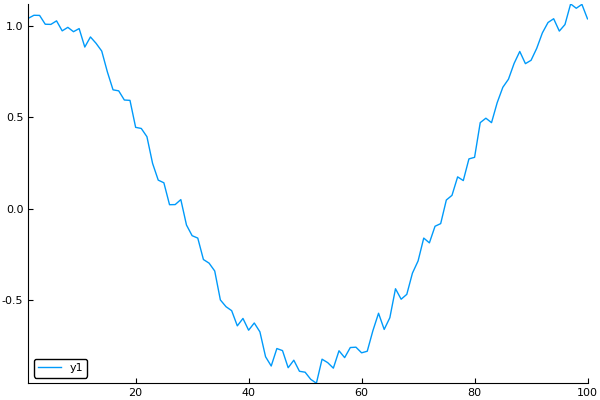

In [12]:
@time H̃(g,H(w,g));
plot(g)

#### Form Schur complement matrix and its inverse

First create a grid and a Laplacian operator on it

In [12]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
q = Edges(Dual,(nx,ny));

In [13]:
L = plan_laplacian(size(w),with_inverse=true)
L⁻¹!(v::T,w::T) where {T} = A_ldiv_B!(v,L,w)

L⁻¹! (generic function with 1 method)

Now create a shape, with discrete points and associated regularization and interpolation operator

In [14]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [15]:
H = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
H̃ = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true,filter=true)

Regularization/interpolation operator with filtered interpolation
  128 points in grid with cell area 0.000248


In [16]:
PS = SaddleSystem(w,f,L⁻¹!,H,H,issymmetric=true,isposdef=true)

Saddle system with state of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129} and force of type Whirl.Fields.ScalarData{128}

  0.334070 seconds (931.94 k allocations: 457.071 MiB, 10.65% gc time)


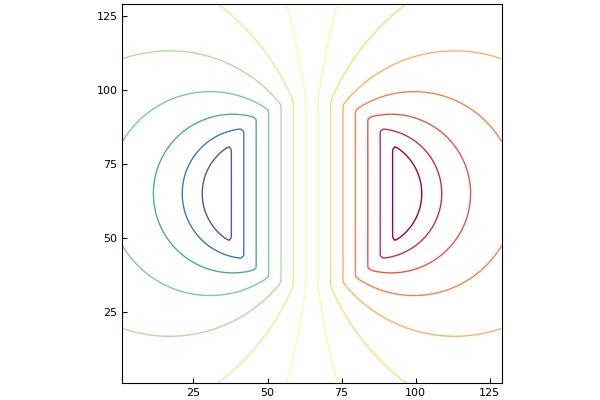

In [21]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb-1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w)
rhs = (w,ψb)
@time A_ldiv_B!((ψ,f),PS,rhs)
plot(ψ)

In [72]:
fex = -2*cos.(θ[1:n]);
norm(f1-fex,Inf)

0.033162807861191856

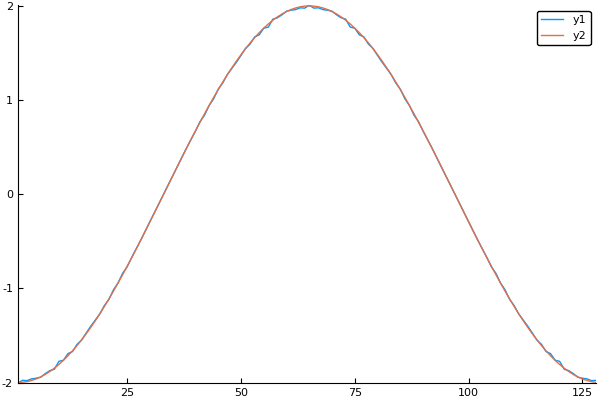

In [73]:
plot(f1)
plot!(-2*cos.(θ[1:n]))

### Test time marching

In [33]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
q = Edges(Dual,(nx,ny));

In [34]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [35]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)

Regularization/interpolation operator with non-filtered interpolation
  128 points in grid with cell area 0.000248


In [36]:
r₁(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,w)
r₂(t::Float64) = 1.0

r₂ (generic function with 1 method)

In [50]:
Δt = 1.0
ifherk = IFHERK(w,f,Δt,plan_intfact,E,E,r₁,r₂)

Order-3 IF-HERK system with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129}
   Force of type Whirl.Fields.ScalarData{128}
   Time step size 1.0


In [51]:
function (scheme::IFHERK{NS,FH,FB1,FB2,FR1,FR2,TU,TF})(t::Float64,u::TU,f::TF) where {NS,FH,FB1,FB2,FR1,FR2,TU,TF}
# Advance the solution by one time step
@get scheme (Δt,rk,H,S,B₁ᵀ,B₂,r₁,r₂,qᵢ,w,fbuffer)

# H[i] corresponds to H(i,i+1) = H((cᵢ - cᵢ₋₁)Δt)
    
# first stage, i = 1    
tᵢ₊₁ = t + Δt*rk.c[1]
qᵢ .= u # qᵢ₊₁ = H(s.u) without H
w[1] .= Δt*rk.a[1,1]*r₁(u,tᵢ₊₁) # Hgᵢ = Δt*rk.a[1,1]*H(r₁(sᵢ,tᵢ₊₁)) without H    
u .+= w[1] # r₁ = qᵢ + gᵢ   
fbuffer .= r₂(tᵢ₊₁)
A_ldiv_B!((u,f),S[1],(u,fbuffer))  # solve saddle point system
H[1](w[1],w[1]) # H(i,i+1)gᵢ
H[1](qᵢ,qᵢ) # qᵢ₊₁ = H(i,i+1)qᵢ 
    
for i = 2:NS-1
   tᵢ₊₁ = t + Δt*rk.c[i]
   w[i-1] .= (w[i-1]-S[i-1].A⁻¹B₁ᵀf)/(Δt*rk.a[i-1,i-1]) # w(i,i-1)
   w[i] .= Δt*rk.a[i,i]*r₁(u,tᵢ₊₁) # gᵢ     
   u .= qᵢ .+ w[i] # r₁
   for j = 1:i-1
     u .+= Δt*rk.a[i,j]*w[j]   
   end
   fbuffer .= r₂(tᵢ₊₁) # r₂
   A_ldiv_B!((u,f),S[i],(u,fbuffer))
        
   H[i](qᵢ,qᵢ) # qᵢ₊₁ = H(i,i+1)qᵢ
   for j = 1:i
      H[i](w[j],w[j]) # for j = i, this sets H(i,i+1)gᵢ
   end
        
end
i = NS
tᵢ₊₁ = t + Δt*rk.c[i]    
w[i-1] .= (w[i-1]-S[i-1].A⁻¹B₁ᵀf)/(Δt*rk.a[i-1,i-1]) # w(i,i-1)
u .= qᵢ .+ Δt*rk.a[i,i]*r₁(u,tᵢ₊₁)    
for j = 1:i-1
  u .+= Δt*rk.a[i,j]*w[j]   
end
fbuffer .= r₂(tᵢ₊₁) # r₂    
A_ldiv_B!((u,f),S[i],(u,fbuffer))
f ./= Δt*rk.a[NS,NS]    
    
#= 
#sᵢ = deepcopy(s)
#sᵢ₊₁ = deepcopy(sᵢ)
#sᵢ₊₁.t = s.t + Δt*rk.c[1]
#A⁻¹gᵢ = Δt*rk.a[1][1]*A⁻¹(scheme.r₁(sᵢ,tᵢ₊₁))
#qᵢ₊₁ = A⁻¹(s.u)
#sᵢ₊₁.u = qᵢ₊₁ + A⁻¹gᵢ
#sᵢ₊₁.f = -P(S⁻¹(B₂(sᵢ₊₁.u) - r₂(sᵢ,sᵢ₊₁.t)))
#A⁻¹B₁ᵀf = A⁻¹(B₁ᵀ(sᵢ₊₁.f))
#@. sᵢ₊₁.u -= A⁻¹B₁ᵀf

w = []
for i = 2:rk.nstage-1
  sᵢ = deepcopy(sᵢ₊₁)
  sᵢ₊₁.t = s.t + Δt*rk.c[i]
  push!(w,(A⁻¹gᵢ-A⁻¹B₁ᵀf)/(Δt*rk.a[i-1][i-1]))
  for j = 1:i-1
    w[j] = A⁻¹(w[j])
  end
  A⁻¹gᵢ = Δt*rk.a[i][i]*A⁻¹(r₁(sᵢ,sᵢ₊₁.t))
  qᵢ₊₁ = A⁻¹(qᵢ₊₁)
  @. sᵢ₊₁.u = qᵢ₊₁ + A⁻¹gᵢ
  for j = 1:i-1
    @. sᵢ₊₁.u += Δt*rk.a[i][j]*w[j]
  end
  sᵢ₊₁.f = -P(S⁻¹(B₂(sᵢ₊₁.u) - r₂(sᵢ,sᵢ₊₁.t)))
  A⁻¹B₁ᵀf = A⁻¹(B₁ᵀ(sᵢ₊₁.f))
  @. sᵢ₊₁.u -= A⁻¹B₁ᵀf
end

# In final stage, A⁻¹ is assumed to be the identity
i = rk.nstage
sᵢ = deepcopy(sᵢ₊₁)
sᵢ₊₁.t = s.t + Δt*rk.c[i]
push!(w,(A⁻¹gᵢ-A⁻¹B₁ᵀf)/(Δt*rk.a[i-1][i-1]))
for j = 1:i-1
  w[j] = w[j]
end
A⁻¹gᵢ = Δt*rk.a[i][i]*r₁(sᵢ,sᵢ₊₁.t)
sᵢ₊₁.u = qᵢ₊₁ + A⁻¹gᵢ
for j = 1:i-1
  @. sᵢ₊₁.u += Δt*rk.a[i][j]*w[j]
end
sᵢ₊₁.f = -P(S₀⁻¹(B₂(sᵢ₊₁.u) - r₂(sᵢ,sᵢ₊₁.t)))
A⁻¹B₁ᵀf = B₁ᵀ(sᵢ₊₁.f)
@. sᵢ₊₁.u -= A⁻¹B₁ᵀf

# Finalize
s = deepcopy(sᵢ₊₁)
s.f /= Δt*rk.a[rk.nstage][rk.nstage]

return s

=#

end

In [52]:
t = 0.0
w = Nodes(Dual,(nx,ny));

In [64]:
ifherk(t,w,f);
maximum(w)

1.0752619181072423

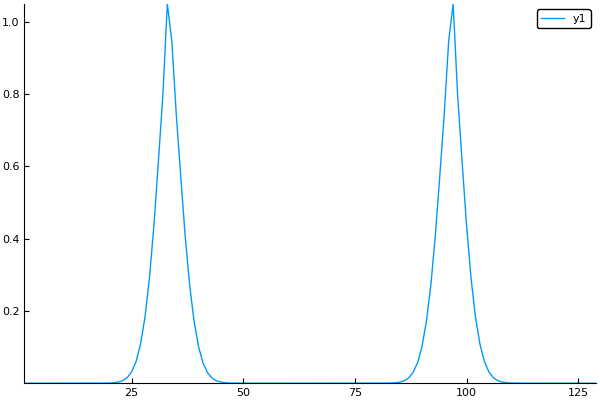

In [65]:
plot(w[65,:])

#### Scalar data onto primal nodal field

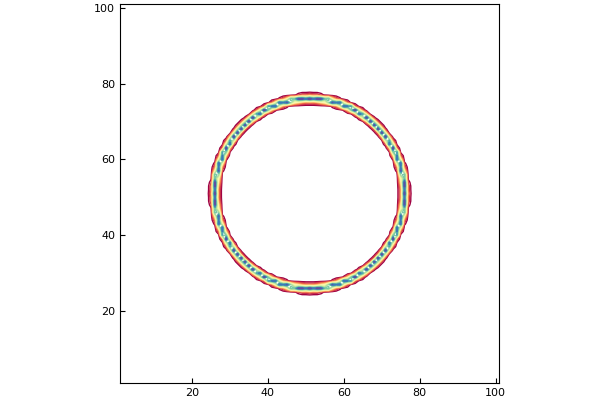

In [13]:
H(w̃,g)
plot(w̃)

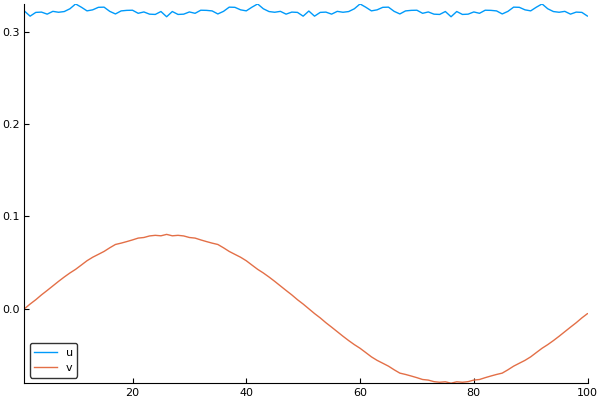

In [49]:
f2 = VectorData(X);
H(f2,q)
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

In [50]:
function fcn!((x,y)::Tuple{Float64})
    println(x)
end

LoadError: [91msyntax: "(x,y)" is not a valid function argument name[39m

### Testing new field types and operators

In [8]:
i = 5; j = 5;

In [9]:
nx = 12; ny = 12;

In [2]:
w = Nodes(Dual,(5,4))
w .= reshape(1:20,5,4)
w∘w
C = Curl()
D = Divergence()
D*(C*w)

Whirl.Fields.Nodes{Whirl.Fields.Primal,5,4} data
Printing in grid orientation (lower left is (1,1)):
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [5]:
w

Whirl.Fields.Nodes{Whirl.Fields.Dual,5,4} data
Printing in grid orientation (lower left is (1,1)):
 16.0  17.0  18.0  19.0  20.0
 11.0  12.0  13.0  14.0  15.0
  6.0   7.0   8.0   9.0  10.0
  1.0   2.0   3.0   4.0   5.0

In [28]:
w = Nodes(Dual,(12,12));
w[4,4] = 1.0;
q = Edges(Primal,w)
curl!(q,w)

Whirl.Fields.Edges{Whirl.Fields.Primal,12,12} data
u (in grid orientation):
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
v (in grid orientation):
 0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0

In [7]:
typeof((Nodes(Primal,(8,6)),Nodes(Primal,(8,6))))

Tuple{Whirl.Fields.Nodes{Whirl.Fields.Primal,8,6},Whirl.Fields.Nodes{Whirl.Fields.Primal,8,6}}

In [6]:
q = Edges(Dual,(8,6));
p = deepcopy(q);
q.u[3,2] = 0.3;
p.u[3,2] = 0.2;
p∘q

Whirl.Fields.Edges{Whirl.Fields.Dual,8,6} data
u (in grid orientation):
 0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.06  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0
v (in grid orientation):
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
q = Edges{Dual, 5, 4}()
q.u .= reshape(1:16, 4, 4)
q.v .= reshape(1:15, 5, 3)
v = Edges{Primal, 5, 4}()
Fields.shift!(v,q)
v.v

4×4 Array{Float64,2}:
 0.0  4.0   9.0  0.0
 0.0  5.0  10.0  0.0
 0.0  6.0  11.0  0.0
 0.0  7.0  12.0  0.0

In [5]:
nx = 100; ny = 100;
i = 40; j = 50;
w = Nodes(Dual,(nx,ny))
w[i,j] = 1.0
E = IntFact(5,w)
E25 = IntFact(2.5,w)

Integrating factor with parameter 2.5 on a (nx = 100, ny = 100) grid

In [6]:
E25*(E25*w)≈E*w

true

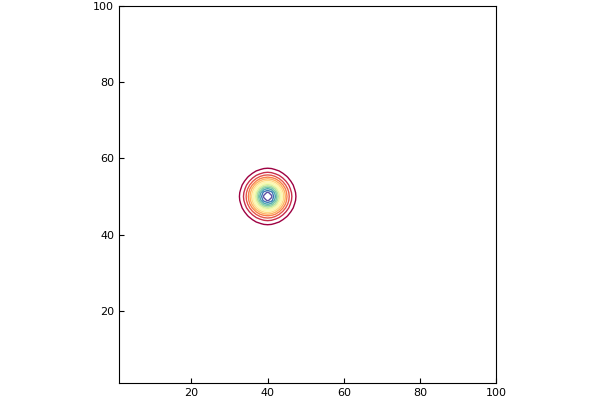

In [11]:
plot(E*w)

In [14]:
cellzero = Nodes(Dual,(nx,ny))
nodezero = Nodes(Primal,cellzero)
facezero = Edges(Primal,cellzero)
dualfacezero = Edges(Dual,cellzero)

cellunit = deepcopy(cellzero)
cellunit[i,j] = 1.0

1.0

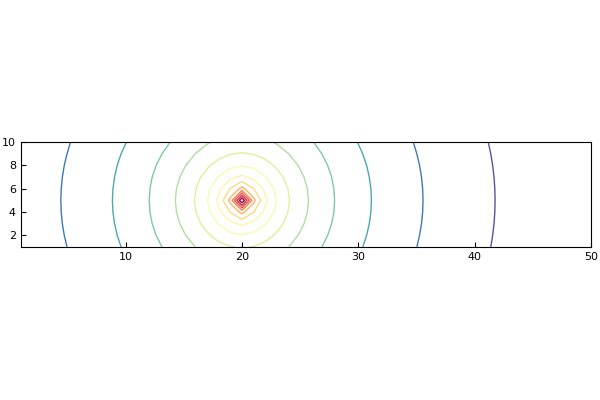

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [4]:
w = Nodes(Dual,(50,10));
w[20,5] = 1.0
L = plan_laplacian(w,with_inverse=true)
plot(L\w)

In [15]:
E = plan_intfact(1.0,(nx,ny))

Integrating factor with parameter 1.0 on a (nx = 12, ny = 12) grid

In [16]:
E! = plan_intfact!(1.0,(nx,ny))

In-place integrating factor with parameter 1.0 on a (nx = 12, ny = 12) grid

In [19]:
w = deepcopy(cellunit)

Whirl.Fields.Nodes{Whirl.Fields.Dual,12,12} data
Printing in grid orientation (lower left is (1,1)):
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [28]:
plot(E!*w)

Whirl.Fields.Nodes{Whirl.Fields.Dual,12,12} data
Printing in grid orientation (lower left is (1,1)):
 0.000647717  0.00101769  0.0013291   0.00154123  …  0.000549966  0.00032359 
 0.00110085   0.00172964  0.00225891  0.00261944     0.00093471   0.000549966
 0.00160225   0.00251744  0.00328777  0.00381252     0.00136044   0.00080046 
 0.00211737   0.0033268   0.00434479  0.00503824     0.00179783   0.00105781 
 0.00260182   0.00408796  0.00533887  0.00619098     0.00220916   0.00129983 
 0.00299675   0.00470847  0.00614925  0.0071307   …  0.00254449   0.00149713 
 0.00323949   0.00508986  0.00664734  0.0077083      0.0027506    0.0016184  
 0.00327836   0.00515094  0.00672712  0.0078008      0.00278361   0.00163782 
 0.00308502   0.00484716  0.00633037  0.00734074     0.00261944   0.00154123 
 0.0026604    0.00418001  0.00545907  0.00633037     0.00225891   0.0013291  
 0.00203707   0.00320062  0.00418001  0.00484716  …  0.00172964   0.00101769 
 0.00129651   0.00203707  0.0026604   0.0

In [5]:
C = Curl()
C*w

Whirl.Fields.Edges{Whirl.Fields.Primal,50,10} data
u (in grid orientation):
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
v (in grid orientation):
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [8]:
Nodes(Primal,cellunit)

Whirl.Fields.Nodes{Whirl.Fields.Primal,12,12} data
Printing in grid orientation (lower left is (1,1)):
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [18]:
typeof(nodeunit).parameters[2:3]

svec(12, 12)

In [397]:
w = Fields.Nodes{Fields.Dual, 5, 4}()
w .= reshape(1:20, 5, 4)
Ww = Fields.shift(w)

Whirl.Fields.Dual edge data
u (in grid orientation):
4×4 Array{Float64,2}:
  0.0   0.0   0.0   0.0
 11.5  12.5  13.5  14.5
  6.5   7.5   8.5   9.5
  0.0   0.0   0.0   0.0
v (in grid orientation):
3×5 Array{Float64,2}:
 0.0  14.5  15.5  16.5  0.0
 0.0   9.5  10.5  11.5  0.0
 0.0   4.5   5.5   6.5  0.0

In [328]:
s = Fields.Nodes{Fields.Dual, 5, 4}()
s .= rand(5, 4)
Fields.divergence(Fields.curl(s))

Whirl.Fields.Nodes{Whirl.Fields.Primal,5,4} data
Printing in grid orientation (lower left is (1,1)):
4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [317]:
v = Fields.Nodes(Fields.Dual,(12,12))
v[i,j] = 1.0
v

Whirl.Fields.Nodes{Whirl.Fields.Dual,12,12} data
Printing in grid orientation (lower left is (1,1)):
12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
L = plan_laplacian(nx,ny;with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 12, ny = 12) grid with spacing 1.0

In [467]:
faceones = deepcopy(facezero)
fill!(cellones,1.0)

Whirl.Fields.Nodes{Whirl.Fields.Dual,12,12} data
Printing in grid orientation (lower left is (1,1)):
12×12 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [13]:
L*(L\cellunit)

Whirl.Fields.Nodes{Whirl.Fields.Dual,12,12} data
Printing in grid orientation (lower left is (1,1)):
 0.0   0.0           0.0          …   0.0           0.0          0.0
 0.0   1.11022e-16  -2.22045e-16      3.33067e-16  -1.11022e-16  0.0
 0.0  -1.11022e-16   9.99201e-16      1.11022e-16   3.33067e-16  0.0
 0.0  -5.55112e-17  -1.11022e-16      4.44089e-16  -9.99201e-16  0.0
 0.0   7.21645e-16   2.22045e-16      1.22125e-15   3.33067e-16  0.0
 0.0  -6.10623e-16  -8.32667e-16  …  -3.33067e-16   0.0          0.0
 0.0   2.77556e-16   1.05471e-15      3.33067e-16   0.0          0.0
 0.0  -2.22045e-16  -6.10623e-16      2.22045e-16   9.99201e-16  0.0
 0.0   3.33067e-16   3.33067e-16      0.0          -4.44089e-16  0.0
 0.0  -6.10623e-16  -4.44089e-16     -1.11022e-16   7.77156e-16  0.0
 0.0   7.77156e-16   1.11022e-16  …   4.44089e-16   2.22045e-16  0.0
 0.0   0.0           0.0              0.0           0.0          0.0

In [254]:
w = Fields.Nodes(Fields.Primal,v)
w[i,j] = 1.0
Fields.gradient(w)

Whirl.Fields.Primal edge data
u (in grid orientation):
11×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
v (in grid orientation):
12×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0

In [320]:
q = Fields.Edges(Fields.Dual,v)
q.u[i,j] = 1.0
dq = Fields.gradient(q)
dq.dudy

Whirl.Fields.Nodes{Whirl.Fields.Primal,12,12} data
Printing in grid orientation (lower left is (1,1)):
11×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

# Everything below here is old

### Create a domain

In [92]:
xmin = [-1.0,-1.0]
xmax = [1.0,1.0]
dom = Systems.DualDomain(xmin,xmax)

Domain: xmin = [-1.0, -1.0], xmax = [1.0, 1.0]
number of bodies = 0


#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [93]:
Δx = 0.2
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [1.0, 1.0]
number of bodies = 0
Grid: number of cells = (10,10), Δx = 0.2, xmin = [-1.0, -1.0], xmax = [1.0, 1.0]



### Grid operators

Create some basic grid vectors: zero vectors, uniform one vectors, and "grid unit vectors": a bunch of cell data with zeros everywhere except at one point. These are useful for several steps below.

In [94]:
i = 5; j = 5;
cellzero = zeros(dom.grid.cell);
cellones = ones(dom.grid.cell);
cellunit = copy(cellzero)
cellunit[i,j] = 1.0;
facexzero = zeros(dom.grid.facex);
facexones = zeros(dom.grid.facex);
facexunit = copy(facexzero)
facexunit[i,j] = 1.0;
faceyzero = zeros(dom.grid.facey);
faceyones = ones(dom.grid.facey);
faceyunit = copy(faceyzero)
faceyunit[i,j] = 1.0;
cellzero = zeros(dom.grid.cell);
cellones = ones(dom.grid.cell);
cellunit = copy(cellzero)
cellunit[i,j] = 1.0;
nodezero = zeros(dom.grid.node);
nodeones = ones(dom.grid.node);
nodeunit = copy(nodezero)
nodeunit[i,j] = 1.0;
dualfacexzero = zeros(dom.grid.dualfacex);
dualfacexones = zeros(dom.grid.dualfacex);
dualfacexunit = copy(dualfacexzero)
dualfacexunit[i,j] = 1.0;
dualfaceyzero = zeros(dom.grid.dualfacey);
dualfaceyones = ones(dom.grid.dualfacey);
dualfaceyunit = copy(dualfaceyzero)
dualfaceyunit[i,j] = 1.0;

#### Laplacian of dual cell center data

In [57]:
lapcell = Grids.lap(dom.grid,cellunit)
flipdim(lapcell',1)

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Curl of dual cell center data

In [53]:
curlx,curly = Grids.curl(dom.grid,cellunit)
flipdim(curlx',1)

11×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [64]:
flipdim(curly',1)

12×11 Array{Float64,2}:
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Gradient of dual cell node data

In [62]:
qx,qy = Grids.grad(dom.grid,nodeunit)
flipdim(qx',1)

11×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [63]:
flipdim(qy',1)

12×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Face data curl

In [67]:
cellcurl = Grids.curl(dom.grid,facexunit,faceyzero)
flipdim(cellcurl',1)

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [68]:
cellcurl = Grids.curl(dom.grid,facexzero,faceyunit)
flipdim(cellcurl',1)

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Face data divergence

In [70]:
nodediv = Grids.diverg(dom.grid,facexunit,faceyzero)
flipdim(nodediv',1)

11×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  -1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Face data Laplacian

In [72]:
lapqx,lapqy = Grids.lap(dom.grid,facexunit,faceyzero)
flipdim(lapqx',1)

11×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [81]:
lapqx,lapqy = Grids.lap(dom.grid,facexzero,faceyunit)
flipdim(lapqy',1)

12×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  -4.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Dual face data divergence

In [147]:
celldiv = Grids.dualdiverg(dom.grid,dualfacexunit,dualfaceyzero)
flipdim(celldiv',1)
celldiv[i,j] = celldiv[i+1,j] = 0.0
all(celldiv.==0.0)

true

#### Shift face data to dual face data

In [148]:
qx, qy = Grids.shift(dom.grid,facexunit,faceyzero)
flipdim(qx',1)

12×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.25  0.25  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.25  0.25  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0

In [150]:
qx, qy = Grids.shift(dom.grid,facexzero,faceyunit)
flipdim(qy',1)

11×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.25  0.25  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.25  0.25  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0

#### Shift dual cell center data to dual face data

In [87]:
qx, qy = Grids.shift(dom.grid,cellunit)
flipdim(qx',1)

12×11 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### Shift face data to dual cell center data

In [89]:
cellx = Grids.dualshiftx(dom.grid,facexunit)
flipdim(cellx',1)

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [95]:
celly = Grids.dualshifty(dom.grid,faceyunit)
flipdim(celly',1)

12×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

### Testing composite operations

#### Divergence of a curl

In [98]:
maximum(abs.(Grids.diverg(dom.grid,Grids.curl(dom.grid,cellunit))))==0.0

true

#### Curl of the gradient

In [99]:
maximum(abs.(Grids.curl(dom.grid,Grids.grad(dom.grid,nodeunit))))==0.0

true

###  LGF and integrating factor

In [102]:
# Set up the LGF and integrating factor tables
@time Grids.lgf_table!(dom.grid);
α = 5.0
@time Grids.q_table!(dom.grid,α);

  0.002609 seconds (1.94 k allocations: 2.125 MiB)
  0.000277 seconds (3.38 k allocations: 79.375 KiB)


In [108]:
# This is the discrete convolution of the LGF with the grid unit vector
@time s = Grids.L⁻¹(dom.grid)(cellunit);

  0.000044 seconds (14 allocations: 10.422 KiB)


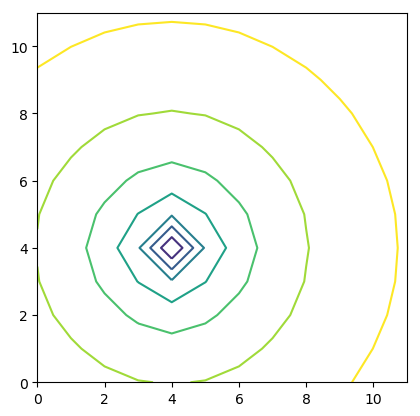

(0.0, 11.0, 0.0, 11.0)

In [110]:
# plot this
contour(s)
axis("scaled")

In [113]:
laps = Grids.lap(dom.grid,s)
laps[i,j]≈1.0

true

### Create a body

In [2]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807


In [ ]:
dom = Systems.add_body(dom,b)

### Construct grid and body-grid operators

In [27]:
# This is the discrete convolution of the integrating factor with the grid unit vector
# The result is just the integrating factor field, but shifted to the center specified
# in the grid unit vector.
@time s = Grids.Q(dom.grid)(wunit);

  0.139277 seconds (120.97 k allocations: 7.536 MiB)


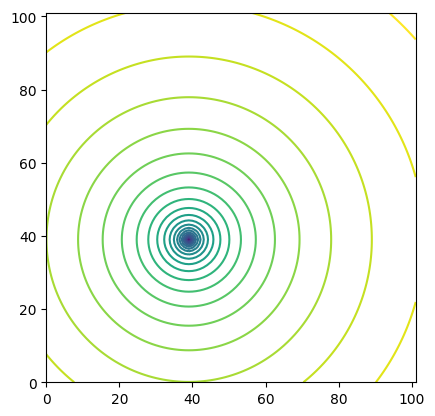

(0.0, 101.0, 0.0, 101.0)

In [15]:
# plot this
contour(s,31)
axis("scaled")

#### Construct and plot the C<sup>T</sup> E<sub>y</sub><sup>T</sup> operator

In [5]:
@time Systems.construct_CᵀEᵀ!(dom)

Computing Eᵀ...100%|████████████████████████████████████| Time: 0:00:01


  5.011396 seconds (2.45 M allocations: 356.706 MiB, 1.69% gc time)


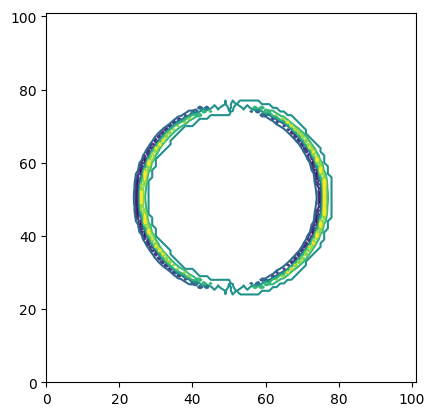

(0.0, 101.0, 0.0, 101.0)

In [17]:
contour(reshape(dom.CᵀEᵀ[1]*ones(dom.nbodypts),size(dom.grid.cell)))
axis("scaled")

In [35]:
# Create a "grid unit vector": a bunch of cell data with zeros everywhere except at one point.
# This is useful for visualizing the LGF and the integrating factor
wxunit = zeros(dom.grid.facex);
wxunit[4,4] = 1.0;
wyunit = zeros(dom.grid.facey);
wyunit[1,1] = 1.0;

In [36]:
wxunit

6×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [41]:
dualshiftx(dom.grid,wxunit)

6×6 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [40]:
function dualshiftx!(vx,ir::UnitRange{Int},jr::UnitRange{Int},facex)
    irx = ir.start:ir.stop
    jry = jr.start:jr.stop-1
    @. vx[irx,jry] = 0.5(facex[irx,jry]+facex[irx,jry+1])
    # @. vy[ir,jry] = 0.5(facey[ir,jry]+facey[ir+1,jry])
    nothing
end
function dualshiftx(g::DualPatch,facex)
    cellx = zeros(g.cell)
    dualshiftx!(cellx,g.facexint[1],g.facexint[2],facex)
    cellx
end

dualshiftx (generic function with 1 method)